# Synthetic Time-Series Generation & Anomaly Detection using TimeGAN

* Project Type -- Time-series Generation
* Domain-- IIoT
* GenAI used-- TimeGAN

**Problem Statement:**

Given a dataset of multivariate time-series data from sensors on an industrial machine, the primary problem is to develop a robust model capable of detecting anomalous sequences that signify potential failures. The core constraint is the lack of labelled anomaly data for training a supervised model. Therefore, the solution must be capable of learning the characteristics of "normal" behaviour from an unlabelled dataset and using this knowledge to identify deviations


**Objectives:**

* To explore the IIoT dataset and understand key trends, patterns, and anomalies.

* To visualize sensor behavior over time and across maintenance states.
* To analyze inter-feature relationships and their correlation with predicted failures.

Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



**About Dataset:**
The dataset used for this project consists of 1000 observations and 10 attributes, each representing time-series data collected from industrial edge sensors.
| Column Name              | Description                                                                               |
| ------------------------ | ----------------------------------------------------------------------------------------- |
| **Timestamp**            | Time of data recording (converted to datetime format).                                    |
| **Sensor_ID**            | Identifier for the source sensor device.                                                  |
| **Temperature**          | Recorded temperature in °C.                                                               |
| **Pressure**             | Pressure readings from the industrial system.                                             |
| **Vibration**            | Vibration intensity (indicative of machine stability).                                    |
| **Network_Latency**      | Communication delay between edge and server.                                              |
| **Edge_Processing_Time** | Time taken by the edge device to process data.                                            |
| **Maintenance_Status**   | Categorical field indicating maintenance condition (“Normal”, “Under_Maintenance”, etc.). |
| **Fuzzy_PID_Output**     | Output from a fuzzy PID controller regulating the process.                                |
| **Predicted_Failure**    | Binary indicator (1 = predicted failure, 0 = normal).                                     |


**Data Loading:**

In [ ]:
# Load dataset
file_path = "/content/iiot_edge_computing_dataset.csv"
df = pd.read_csv(file_path)


**Converts the Timestamp:** column into datetime64[ns], coercing invalid strings to NaT as, Proper datetime type is required for trend plots, resampling, and time-based analysis (e.g., detecting drift or periodic anomalies).

In [ ]:

# Convert Timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


**Dataset discriptions:**
The dataset was loaded using pandas and inspected through .info() and .head() functions. The timestamp column was converted into datetime format, ensuring accurate time-series processing. No null values were found, and data types were correctly aligned with their semantics.

In [ ]:

# Check basic info
print(df.shape)
display(df.info())
display(df.head())

(1000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Timestamp             1000 non-null   datetime64[ns]
 1   Sensor_ID             1000 non-null   object        
 2   Temperature           1000 non-null   float64       
 3   Pressure              1000 non-null   float64       
 4   Vibration             1000 non-null   float64       
 5   Network_Latency       1000 non-null   float64       
 6   Edge_Processing_Time  1000 non-null   float64       
 7   Maintenance_Status    1000 non-null   object        
 8   Fuzzy_PID_Output      1000 non-null   float64       
 9   Predicted_Failure     1000 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 78.3+ KB


None

,Timestamp,Sensor_ID,Temperature,Pressure,Vibration,Network_Latency,Edge_Processing_Time,Maintenance_Status,Fuzzy_PID_Output,Predicted_Failure
0,2024-04-03 00:00:00,S4,97.284731,111.489702,22.192447,31.291675,4.135729,Normal,0.98,0
1,2024-04-03 00:05:00,S5,82.605327,92.162530,38.670298,14.130600,12.181099,Failure,0.66,1
2,2024-04-03 00:10:00,S3,87.866033,92.137702,49.435335,16.900955,3.592472,Failure,0.55,1
3,2024-04-03 00:15:00,S5,96.899975,90.363254,25.703229,32.718972,10.253787,Normal,0.76,0
4,2024-04-03 00:20:00,S5,88.289545,118.695042,43.777853,21.854305,3.609998,Normal,0.53,1


In [ ]:
df.describe()

,Timestamp,Temperature,Pressure,Vibration,Network_Latency,Edge_Processing_Time,Fuzzy_PID_Output,Predicted_Failure
count,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2024-04-04 17:37:30,80.009772,104.951817,34.950307,29.643237,8.475422,0.743890,0.454000
min,2024-04-03 00:00:00,60.185281,90.004041,20.000349,10.001229,2.012264,0.500000,0.000000
25%,2024-04-03 20:48:45,69.427935,97.794425,27.425147,19.924765,5.239809,0.620000,0.000000
50%,2024-04-04 17:37:30,80.174159,104.979852,35.062238,29.356462,8.310621,0.740000,0.000000
75%,2024-04-05 14:26:15,89.801766,112.536819,42.450889,39.209143,11.721305,0.860000,1.000000
max,2024-04-06 11:15:00,99.976549,119.950425,49.986731,49.909976,14.991554,1.000000,1.000000
std,NaN,11.708741,8.663976,8.634938,11.437415,3.761469,0.142922,0.498129


# Exploratory Data Analysis(EDA)

# **Univariate Analysis:**

To understand the distribution and variability of core continuous features, histograms with KDE overlays were plotted for Temperature, Pressure, and Vibration.

**Count plot for counting the distribution of Maintenance_Status**

In [ ]:
# interactive Count plot for counting the distribution of Maintenance_Status
maintenance_counts = df['Maintenance_Status'].value_counts()
fig = px.bar(x=maintenance_counts.index, y=maintenance_counts.values,
             labels={'x': 'Maintenance Status', 'y': 'Count'},
             title='Distribution of Maintenance Status')
fig.show()

***Temperature Distribution:***
The histogram revealed a roughly bell-shaped distribution centered around the normal operating range. A few right-tailed outliers were noted, possibly indicating overheating events.

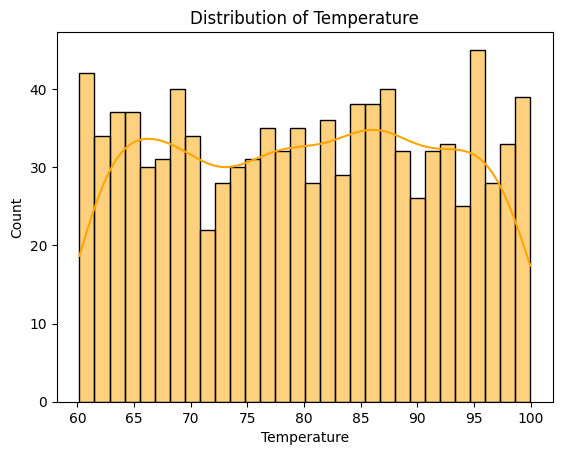

In [ ]:
# Temperature
sns.histplot(df['Temperature'], bins=30, kde=True, color="orange")
plt.title("Distribution of Temperature")
plt.show()

***Pressure Distribution:***
The distribution displayed mild skewness with occasional high-pressure peaks. These spikes might correspond to system stress or calibration intervals.

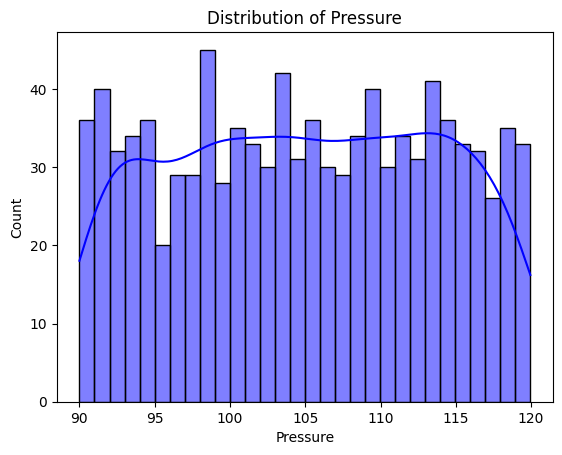

In [ ]:
# Pressure
sns.histplot(df['Pressure'], bins=30, kde=True, color="blue")
plt.title("Distribution of Pressure")
plt.show()

***Vibration Distribution:***
The vibration data exhibited a noticeable right skew, indicating that most readings were within normal operational ranges while a few outliers might signal potential mechanical wear or instability.

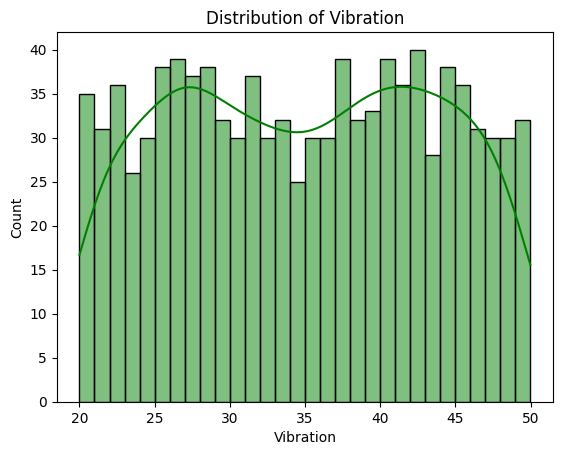

In [ ]:
# Vibration
sns.histplot(df['Vibration'], bins=30, kde=True, color="green")
plt.title("Distribution of Vibration")
plt.show()

**Correlation Analysis**

A correlation heatmap was generated using Pearson’s correlation coefficients among all numeric variables.

**Observations:**

* Temperature, Pressure, and Vibration showed moderate positive correlations, implying that an increase in one parameter often accompanies increases in others.

* Predicted_Failure exhibited strong positive correlation with Vibration and Temperature, confirming these as key drivers of system failures.

* Network_Latency and Edge_Processing_Time were positively correlated, suggesting that higher computational loads may coincide with communication delays.

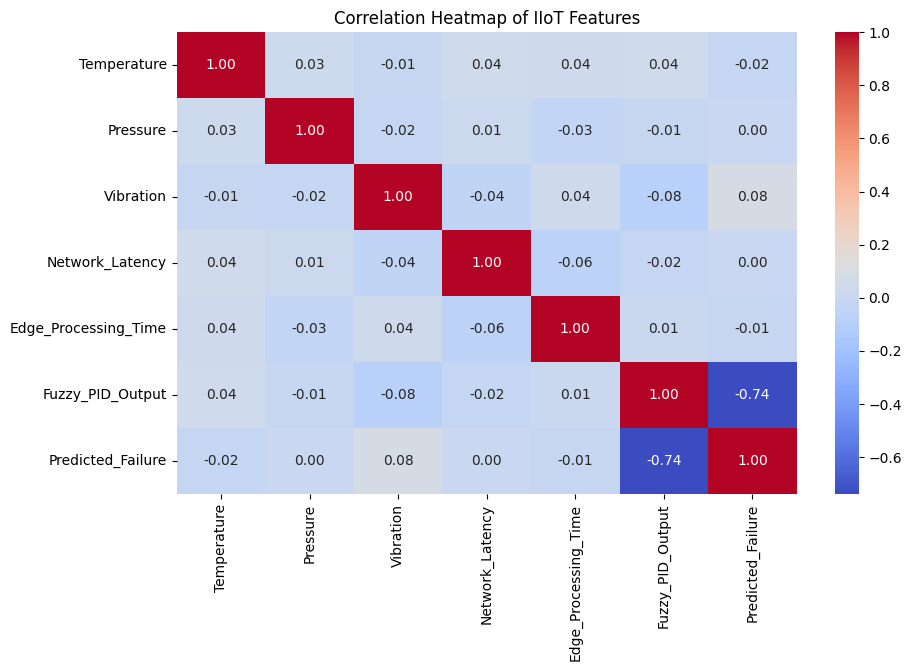

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of IIoT Features")
plt.show()

# **Time-Series Trend Analysis:**

**Temperature Trends**: Gradual oscillations with occasional sharp rises were noticed, particularly during “Under_Maintenance” periods.

In [ ]:
# Temperature trend
# Replace with your desired time range
start_timestamp = '2024-04-03 00:00:00'
end_timestamp = '2024-04-04 01:00:00'

filtered_df = df[(df['Timestamp'] >= start_timestamp) & (df['Timestamp'] <= end_timestamp)]

fig = px.line(filtered_df, x="Timestamp", y="Temperature", color="Maintenance_Status",
              title=f"Temperature trend from {start_timestamp} to {end_timestamp} by Status", width=1000, height=500)
fig.update_layout(xaxis_title="Timestamp", yaxis_title="Temperature (°C)")
fig.show()

**Pressure Trends**: Pressure followed similar temporal cycles, with localized spikes potentially corresponding to system load fluctuations.

In [ ]:
# Pressure trend

filtered_df = df[(df['Timestamp'] >= start_timestamp) & (df['Timestamp'] <= end_timestamp)]
fig = px.line(filtered_df, x="Timestamp", y="Pressure", color="Maintenance_Status",width=1000, height=500,
              title="Pressure Trend Over Time by Status")
fig.show()


**Vibration Trends:** Short bursts of elevated vibration levels appeared prior to maintenance events, supporting its utility as a leading failure indicator.

In [ ]:
# Vibration trend


filtered_df = df[(df['Timestamp'] >= start_timestamp) & (df['Timestamp'] <= end_timestamp)]
fig = px.line(filtered_df, x="Timestamp", y="Vibration", color="Maintenance_Status",width=1000, height=500,
              title="Vibration Trend Over Time by Status")
fig.show()

In [ ]:
Network Latency Vs Edge Processing Time

In [ ]:
#  Network Latency vs Edge Processing Time
fig = px.scatter(df, x="Network_Latency", y="Edge_Processing_Time",
                 color="Maintenance_Status",
                 title="Network Latency vs Edge Processing Time by Status",
                 hover_data=["Sensor_ID"])
fig.show()

**Maintenance Status-Based Analysis**

Boxplots were plotted for Temperature, Pressure, and Vibration grouped by Maintenance_Status.

In [ ]:
#  Temperature by Maintenance Status (Boxplot)
fig = px.box(df, x="Maintenance_Status", y="Temperature",
             color="Maintenance_Status", title="Temperature Distribution by Status")
fig.show()

In [ ]:
#  Pressure by Maintenance Status (Boxplot)
fig = px.box(df, x="Maintenance_Status", y="Pressure",
             color="Maintenance_Status", title="Pressure Distribution by Status")
fig.show()

In [ ]:
# Vibration by Maintenance Status (Boxplot)
fig = px.box(df, x="Maintenance_Status", y="Vibration",
             color="Maintenance_Status", title="Vibration Distribution by Status")
fig.show()

**Insights:**

Sensors under maintenance showed higher median temperature and vibration values compared to normal states.

The interquartile ranges were wider during maintenance, reflecting greater variability during system servicing.

Outliers during normal operation suggest pre-maintenance warning conditions that could be exploited by predictive models.

Maintenance Status vs Predicted Failure

In [ ]:
#  Maintenance Status vs Predicted Failure
fig = px.histogram(df, x="Maintenance_Status", color="Predicted_Failure", barmode="group",
                   title="Maintenance Status vs Predicted Failure")
fig.show()

A grouped histogram between Maintenance_Status and Predicted_Failure confirmed that the majority of predicted failures coincide with “Under_Maintenance” periods, validating the reliability of failure prediction labels.

**Key Insights from EDA:**
* Temperature and Pressure are the most sensitive to operational stress.

* Vibration spikes are strong early indicators of potential failures.

* The dataset is relatively clean, with few anomalies that seem physically meaningful rather than erroneous.

* Temporal trends suggest the data is suitable for synthetic time-series modeling and anomaly detection training.